# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [4]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [5]:
bbc.sample(5)

,category,text
649,tech,mobile networks seek turbo boost third-generat...
1352,business,india and russia in energy talks india and rus...
1405,sport,greek sprinters won t run again the careers ...
432,sport,england 17-18 france england suffered an eight...
1152,entertainment,housewives lift channel 4 ratings the debut of...


In [6]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [21]:
bbc.isna().sum()

category    0
text        0
new_text    0
dtype: int64

In [8]:
# Your code here
# check value of each category 
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

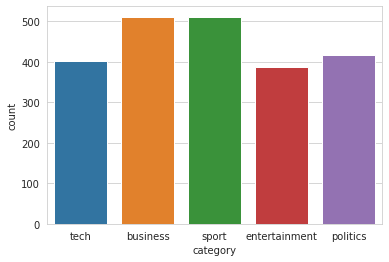

In [9]:
# Visualize category
sns.countplot(x='category', data=bbc)

In [14]:
# Data cleaning
# Import library for preprocessing words
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
import re

In [36]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocessor(text): 
  text = text.lower()
  # words and space only 
  regex = '[^a-z\s]'
  text = re.sub(regex, '', text)

  return text

def steaming_tokenizer(text):
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  return [lem.lemmatize(word, pos='v') for word in text.split()]

In [19]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
 2   new_text  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [26]:
# Model preparing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [23]:
encoder = LabelEncoder()
bbc['category_encoder'] = encoder.fit_transform(bbc['category'])
bbc['category_encoder'].value_counts()

3    511
0    510
2    417
4    401
1    386
Name: category_encoder, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(bbc['text'], bbc['category'], test_size=.2, random_state=42)

vector = TfidfVectorizer(stop_words=stop_words, 
                         tokenizer=steaming_tokenizer,
                         preprocessor=preprocessor)
X_train_vector = vector.fit_transform(X_train)
X_test_vector = vector.transform(X_test)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1780,) (445,) (1780,) (445,)


In [46]:
models = {
    'SVM': SVC(C=10, gamma=0.1),
    'Decision Tree 3': DecisionTreeClassifier(max_depth=3),
    'Decision Tree 5': DecisionTreeClassifier(max_depth=5),
    'Decision Tree 8': DecisionTreeClassifier(max_depth=8),
    'Random Forest': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier()
}

def evaluation(models, X_train, X_test, y_train, y_test):
  idx = []
  scores = {'Accuracy train': [], 'Accuracy test': []}
  for model_name in models.keys(): 
    print(f'Running {model_name}')
    model = models[model_name]
    model.fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(y_train, predictions_train)
    accuracy_test = accuracy_score(y_test, predictions_test)
    
    idx.append(model_name)
    scores['Accuracy train'].append(accuracy_train)
    scores['Accuracy test'].append(accuracy_test)
  
  res = pd.DataFrame(data=scores, index=idx)
  return res

In [47]:
res = evaluation(models, X_train_vector, X_test_vector, y_train, y_test)
res

Running SVM
Running Decision Tree 3
Running Decision Tree 5
Running Decision Tree 8
Running Random Forest
Running Gradient Boosting


,Accuracy train,Accuracy test
SVM,1.000000,0.977528
Decision Tree 3,0.519101,0.507865
Decision Tree 5,0.640449,0.629213
Decision Tree 8,0.790449,0.739326
Random Forest,1.000000,0.952809
Gradient Boosting,1.000000,0.932584
